# Thermo-desorption spectrum

This validation case is a thermo-desorption spectrum measurement perfomed by Baldwin et al. {cite}`baldwin_experimental_2014`.

1 *μ*m thick co-deposited Be-(0.1)D layers were formed via a magnetron sputtering technique.

To reproduce this experiment, 2 intrinsic traps are needed.
The experiment was reproduced with three different BC types.

INSERT BERYLLIUM PARAMETERS HERE

INSERT TRAP PARAMETERS HERE

## FESTIM Code

In [1]:
import festim as F
import fenics as f
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

implantation_temp = 300  # K
resting_time = 306
ramp = 0.3  # K/s
tds_time = (1000 - 300) / ramp

pressure = 1.33e-6  # Pa
T_D2 = 300


class RecombinationFluxDSC(F.RecombinationFlux):
    """Custom dynamically computed surface concentration (DSC) recombination flux according to Baldwin Eq 5"""

    def __init__(self, Kr_0, E_Kr, order, surfaces, delta, gamma, eta) -> None:
        super().__init__(Kr_0, E_Kr, order, surfaces)
        self.delta = delta
        self.gamma = gamma
        self.eta = eta

    def create_form(self, T, solute):
        Kr_0_expr = f.Expression(sp.printing.ccode(self.Kr_0), t=0, degree=1)
        E_Kr_expr = f.Expression(sp.printing.ccode(self.E_Kr), t=0, degree=1)

        Kr = (
            self.delta
            * Kr_0_expr
            * f.exp(-self.gamma * E_Kr_expr / F.k_B / T)
            * f.exp(self.eta * solute)
        )
        self.form = -Kr * solute**self.order
        self.sub_expressions = [Kr_0_expr, E_Kr_expr]


def run_tds(bc_type: str):
    model = F.Simulation()

    vertices = np.concatenate(
        [
            np.linspace(0, 30e-9, num=100),
            np.linspace(30e-9, 1e-6, num=500),
        ]
    )

    model.mesh = F.MeshFromVertices(vertices)

    beryllium = F.Material(
        id=1, D_0=8e-9, E_D=0.364, S_0=2.3e22, E_S=0.174
    )  # m2/s  # eV

    model.materials = beryllium

    model.T = F.Temperature(
        value=sp.Piecewise(
            (implantation_temp, F.t < resting_time),
            (implantation_temp + ramp * (F.t - resting_time), True),
        )
    )

    be_atom_density = 1.85e6 / 9.0122 * 6.022e23  # atom/m3

    pi = 3.14
    M_D2 = 6.68e-27  # kg/H  molecular mass of D2
    flux_from_residual_pressure = F.FluxBC(
        surfaces=1, value=pressure / ((2 * pi**F.k_B * M_D2 * T_D2) ** 0.5), field=0
    )
    if bc_type == "Recombination flux":
        model.boundary_conditions = [
            flux_from_residual_pressure,
            F.RecombinationFlux(Kr_0=3.4e-29, E_Kr=0.28, order=2, surfaces=1),
        ]
        trap_1_density = 0.109 * be_atom_density
        trap_2_density = 3.4e-2 * be_atom_density
        E_p1 = 0.75
        E_p2 = 0.93
    elif bc_type == "Sieverts":
        model.boundary_conditions = [
            F.SievertsBC(
                surfaces=1, S_0=beryllium.S_0, E_S=beryllium.E_S, pressure=pressure
            )
        ]
        trap_1_density = 0.11 * be_atom_density
        trap_2_density = 0.04 * be_atom_density
        E_p1 = 0.805
        E_p2 = 1.070
    elif bc_type == "DSC":
        model.boundary_conditions = [
            flux_from_residual_pressure,
            RecombinationFluxDSC(
                Kr_0=3.4e-29,
                E_Kr=0.28,
                order=2,
                surfaces=1,
                delta=0.1,
                gamma=0.357,
                eta=9.1e-25,
            ),
        ]
        trap_1_density = 0.109 * be_atom_density
        trap_2_density = 0.04 * be_atom_density
        E_p1 = 0.798
        E_p2 = 0.978
    else:
        raise ValueError("unknown bc_type")

    trap_1 = F.Trap(
        k_0=4e12 / be_atom_density,
        E_k=beryllium.E_D,
        p_0=4e12,
        E_p=E_p1,
        density=trap_1_density,
        materials=beryllium,
    )
    trap_2 = F.Trap(
        k_0=4e12 / be_atom_density,
        E_k=beryllium.E_D,
        p_0=4e12,
        E_p=E_p2,
        density=trap_2_density,
        materials=beryllium,
    )
    model.traps = [trap_1, trap_2]

    model.initial_conditions = [
        F.InitialCondition(field=1, value=0.7 * trap_1_density),
        F.InitialCondition(field=2, value=0.3 * trap_2_density),
    ]

    model.dt = F.Stepsize(
        initial_value=0.5,
        stepsize_change_ratio=1.1,
        t_stop=resting_time - 20,
        stepsize_stop_max=20,
        dt_min=1e-05,
    )

    model.settings = F.Settings(
        absolute_tolerance=1e10,
        relative_tolerance=1e-09,
        final_time=tds_time + resting_time,
    )

    list_of_derived_quantities = [
        F.TotalVolume("solute", volume=1),
        F.TotalVolume("retention", volume=1),
        F.TotalVolume("1", volume=1),
        F.TotalVolume("2", volume=1),
        F.AverageVolume("T", volume=1),
        F.HydrogenFlux(surface=1),
        F.HydrogenFlux(surface=2),
    ]

    derived_quantities = F.DerivedQuantities(
        list_of_derived_quantities,
    )

    model.exports = [derived_quantities]

    model.initialise()
    model.run()

    return derived_quantities

## Comparison with experimental data

/home/rekomodo/anaconda3/envs/vv-festim-report-env/lib/python3.11/site-packages/festim/stepsize.py:54: DeprecationWarning: stepsize_stop_max and t_stop attributes will be deprecated in a future release, please use max_stepsize instead
  warnings.warn(
/home/rekomodo/anaconda3/envs/vv-festim-report-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:52: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        2.6e+03 s    Ellapsed time so far: 2.1 s


/home/rekomodo/anaconda3/envs/vv-festim-report-env/lib/python3.11/site-packages/festim/stepsize.py:54: DeprecationWarning: stepsize_stop_max and t_stop attributes will be deprecated in a future release, please use max_stepsize instead
  warnings.warn(


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
Calling FFC just-in-time (JIT) compiler, this may take some time.


/home/rekomodo/anaconda3/envs/vv-festim-report-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:52: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(


Calling FFC just-in-time (JIT) compiler, this may take some time.
100.0 %        2.6e+03 s    Ellapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/rekomodo/anaconda3/envs/vv-festim-report-env/lib/python3.11/site-packages/festim/stepsize.py:54: DeprecationWarning: stepsize_stop_max and t_stop attributes will be deprecated in a future release, please use max_stepsize instead
  warnings.warn(
/home/rekomodo/anaconda3/envs/vv-festim-report-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:52: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(


100.0 %        2.6e+03 s    Ellapsed time so far: 2.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
Calling FFC just-in-time (JIT) compiler, this may take some time.


/home/rekomodo/anaconda3/envs/vv-festim-report-env/lib/python3.11/site-packages/festim/stepsize.py:54: DeprecationWarning: stepsize_stop_max and t_stop attributes will be deprecated in a future release, please use max_stepsize instead
  warnings.warn(
/home/rekomodo/anaconda3/envs/vv-festim-report-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:52: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(


Calling FFC just-in-time (JIT) compiler, this may take some time.
100.0 %        2.6e+03 s    Ellapsed time so far: 3.2 s


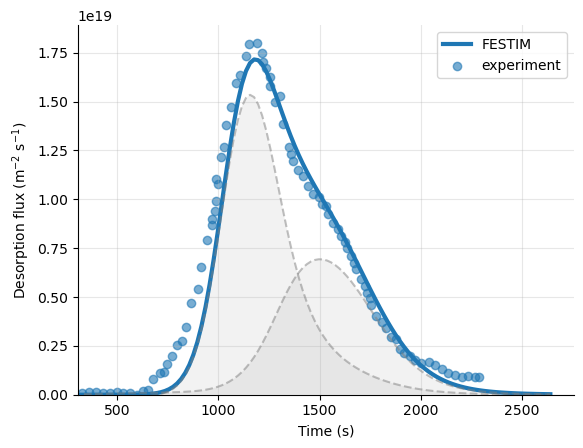

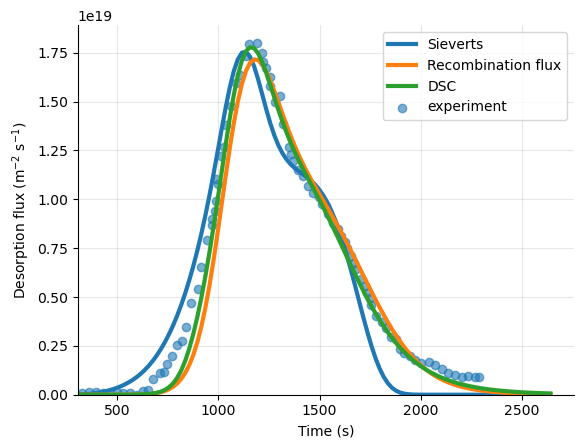

In [3]:


def plot_tds(
    derived_quantities: F.DerivedQuantities, trap_contribution=False, label="FESTIM"
):
    t = derived_quantities.t
    flux_left = derived_quantities.filter(fields="solute", surfaces=1).data
    flux_right = derived_quantities.filter(fields="solute", surfaces=2).data

    flux_total = -np.array(flux_left) - np.array(flux_right)

    trap_1 = derived_quantities.filter(fields="1").data
    trap_2 = derived_quantities.filter(fields="2").data
    T = derived_quantities.filter(fields="T").data

    indexes = np.where(np.array(t) > resting_time)
    t = np.array(t)[indexes]
    T = np.array(T)[indexes]
    flux_total = np.array(flux_total)[indexes]
    trap_1 = np.array(trap_1)[indexes]
    trap_2 = np.array(trap_2)[indexes]
    plt.plot(t, flux_total, linewidth=3, label=label)

    if trap_contribution:
        contribution_trap_1 = -np.diff(trap_1) / np.diff(t)
        contribution_trap_2 = -np.diff(trap_2) / np.diff(t)
        plt.plot(t[1:], contribution_trap_1, linestyle="--", color="grey", alpha=0.5)
        plt.plot(t[1:], contribution_trap_2, linestyle="--", color="grey", alpha=0.5)
        plt.fill_between(t[1:], 0, contribution_trap_1, facecolor="grey", alpha=0.1)
        plt.fill_between(t[1:], 0, contribution_trap_2, facecolor="grey", alpha=0.1)


def plot_experiment():
    exp_data = np.genfromtxt("ref_baldwin.csv", delimiter=",")
    plt.scatter(exp_data[:, 0], exp_data[:, 1], alpha=0.6, label="experiment")


derived_quantities = run_tds("Recombination flux")
plot_tds(derived_quantities, trap_contribution=True)
plot_experiment()
plt.xlim(left=resting_time)
plt.ylim(bottom=0)
plt.grid(alpha=0.3)
plt.ylabel(r"Desorption flux (m$^{-2}$ s$^{-1}$)")
plt.xlabel(r"Time (s)")
plt.gca().spines[["right", "top"]].set_visible(False)
plt.legend()

# comparison models
plt.figure()
for bc_type in ["Sieverts", "Recombination flux", "DSC"]:
    derived_quantities = run_tds(bc_type)
    plot_tds(derived_quantities, trap_contribution=False, label=bc_type)
plot_experiment()
plt.xlim(left=resting_time)
plt.ylim(bottom=0)
plt.grid(alpha=0.3)
plt.ylabel(r"Desorption flux (m$^{-2}$ s$^{-1}$)")
plt.xlabel(r"Time (s)")
plt.gca().spines[["right", "top"]].set_visible(False)
plt.legend()